# UCF50 Human Activity Recognition (HAR) in Tensorflow

In this project we will implement Human Activity Recognition also called as HAR, for this we will be using the UCF50 Dataset provided by the University of Central Florida you can check the website over [here](https://www.crcv.ucf.edu/data/UCF50.php).

The dataset we are using contains 50 action categories, in a video file format. So the problem task comes down to a video classification problem. 

We will be using two different approaches to solve the video classification problem, the first approach will be using the ConvLSTM architecture, this single layer are specifically designied to tackle problems that contain qualities of spatiotemporal. The ConvLSTM layers contains both the Convolutional Layer and the Long Short Term Memory Layer in a single layer.

The second approach to perform video clasification is by using the LRCN architecture, here we will be using the Convolutional Layer and Long Short Term Memory Layer seperately but within a single neural architecture. This approach seperates the spatial qualities to be learnt by the CNN layer and the temporal sequence qualities are learnt by the LSTM layer.   

## Importing Libraries

In [1]:
!pip install pytube rarfile --quiet --upgrade
!pip install numpy tensorflow scikit-learn matplotlib --quiet

In [2]:
import os
import ssl
from urllib.request import urlretrieve
import rarfile
import math
import time
import random
import numpy as np
import datetime as dt
from collections import deque
from sklearn.model_selection import train_test_split

import cv2
from pytube import YouTube
from IPython.display import Video
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, MaxPooling3D, MaxPooling2D, LSTM, TimeDistributed, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [3]:
# Setting seed for randomness
seed=42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

## Downloading Dataset

Downloading the dataset into the data directory

In [4]:
DATA_URL = 'https://www.crcv.ucf.edu/data/UCF50.rar'
DATA_PATH = 'data'
UCF50_DATA_PATH = os.path.join(DATA_PATH, 'UCF50')

if os.path.exists(DATA_PATH):
    print('[INFO] Data already exists.')
else:
    print('[INFO] Downloading data in the data directory.')
    os.mkdir(DATA_PATH)
    ssl._create_default_https_context = ssl._create_unverified_context
    urlretrieve(url=DATA_URL, filename=os.path.join(DATA_PATH, 'UCF50.rar'))

[INFO] Data already exists.


In [5]:
if os.path.exists(UCF50_DATA_PATH):
    print('[INFO] UCF50 Data already exists, skipping extraction process.')
else:
    print(f'[INFO] Extracting data: "{UCF50_DATA_PATH}"')
    r = rarfile.RarFile('data/UCF50.rar')
    r.extractall(DATA_PATH)
    r.close()

[INFO] UCF50 Data already exists, skipping extraction process.


In [6]:
# Details on the downloaded data
for dirpath, dirnames, filenames in os.walk(UCF50_DATA_PATH):
    print(f'There are {len(dirnames)} directories and {len(filenames)} files in "{dirpath}".')

There are 50 directories and 0 files in "data/UCF50".
There are 0 directories and 120 files in "data/UCF50/SkateBoarding".
There are 0 directories and 161 files in "data/UCF50/Drumming".
There are 0 directories and 148 files in "data/UCF50/RockClimbingIndoor".
There are 0 directories and 105 files in "data/UCF50/PlayingPiano".
There are 0 directories and 160 files in "data/UCF50/PoleVault".
There are 0 directories and 142 files in "data/UCF50/GolfSwing".
There are 0 directories and 119 files in "data/UCF50/TrampolineJumping".
There are 0 directories and 123 files in "data/UCF50/HighJump".
There are 0 directories and 114 files in "data/UCF50/PizzaTossing".
There are 0 directories and 156 files in "data/UCF50/SoccerJuggling".
There are 0 directories and 127 files in "data/UCF50/HorseRace".
There are 0 directories and 144 files in "data/UCF50/Skiing".
There are 0 directories and 101 files in "data/UCF50/BreastStroke".
There are 0 directories and 150 files in "data/UCF50/BaseballPitch".
Th

There are 50 different categories containing video files between the range of 100 and 200.

## Visualizing the dataset

Now that the data is downloaded, lets view the data with the labels.

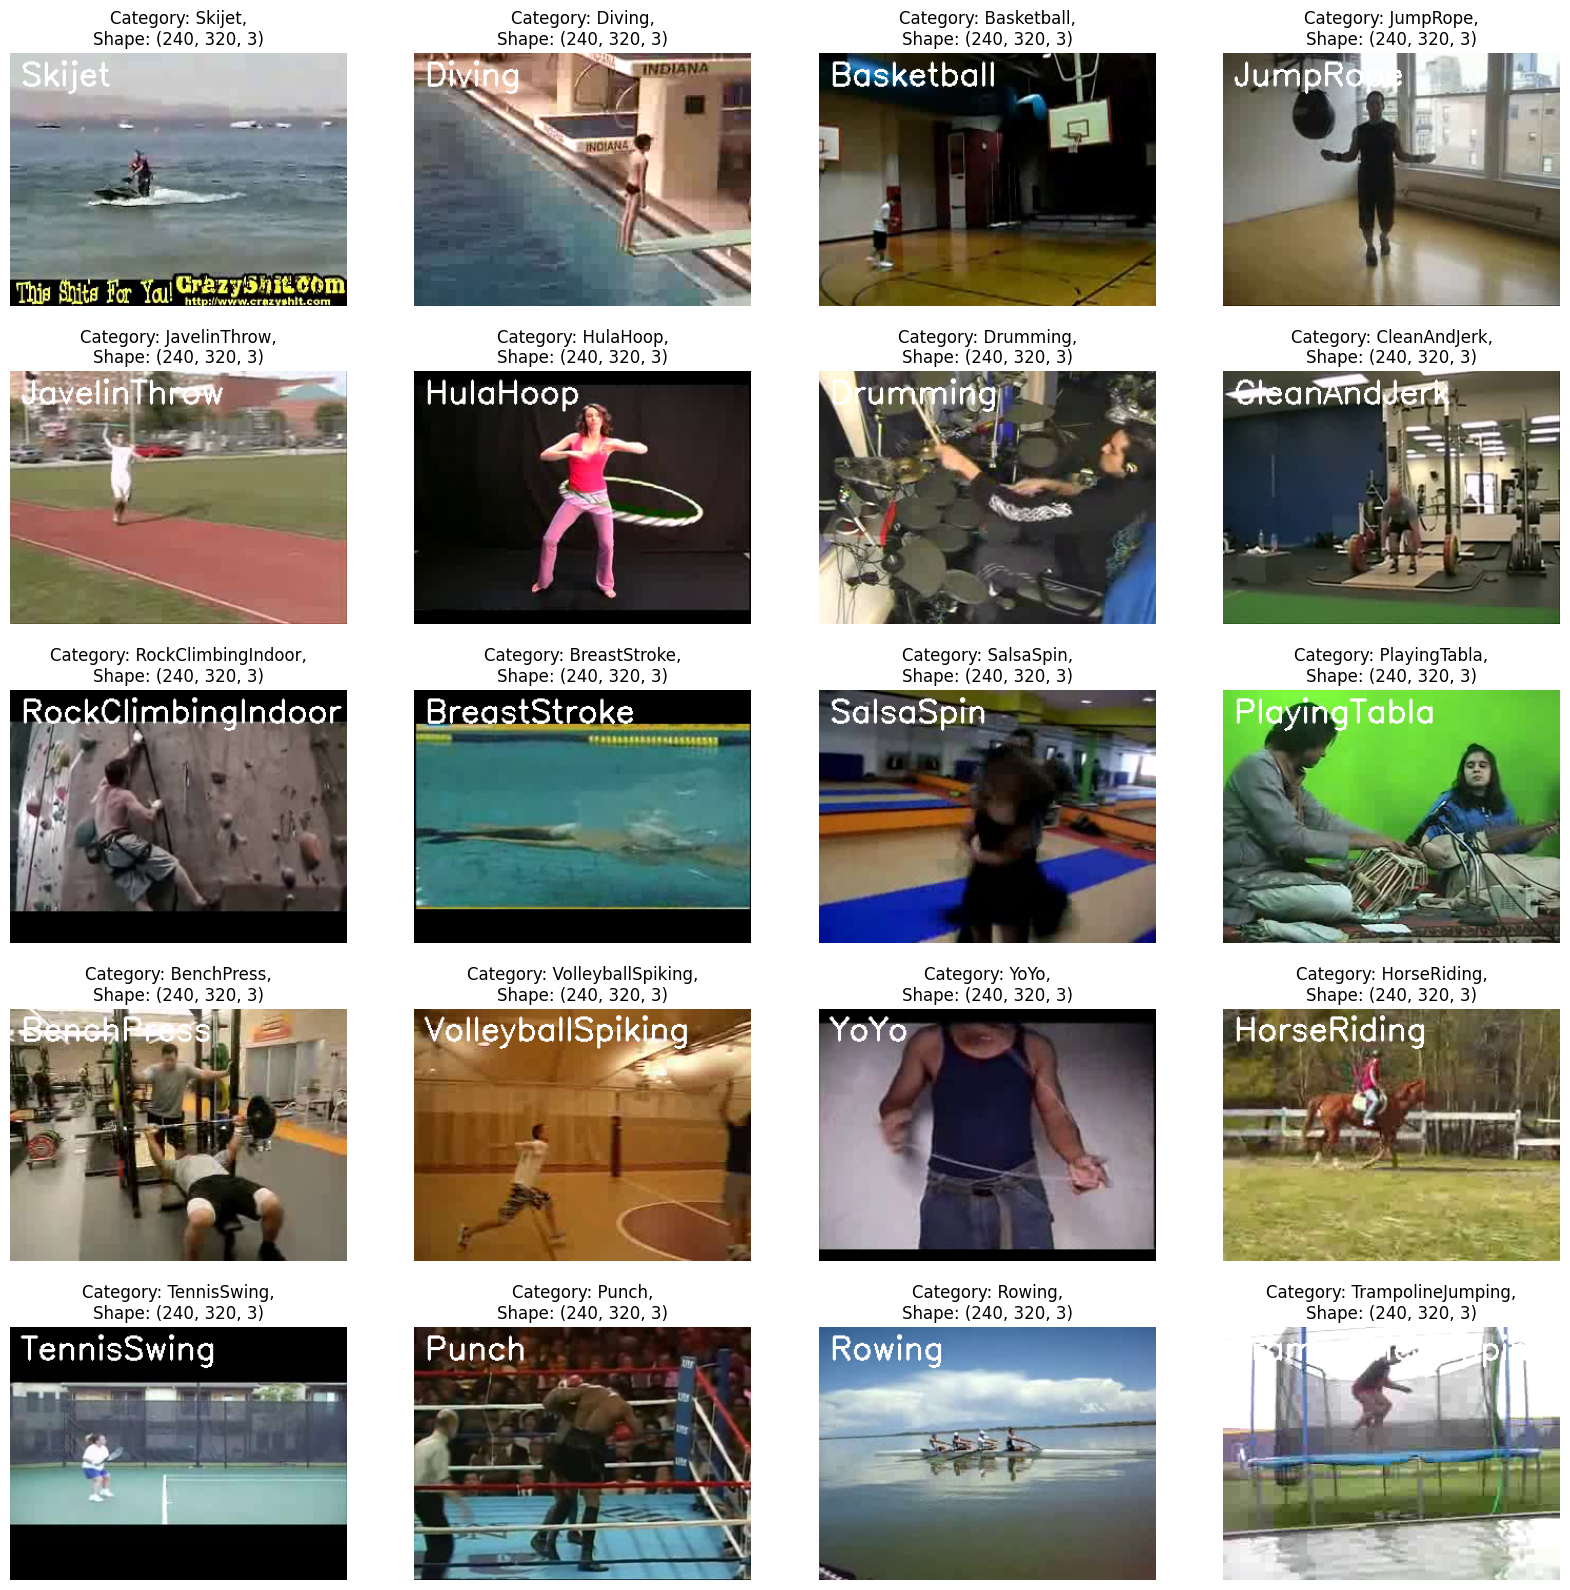

In [7]:
plt.figure(figsize=(20, 20))
classes = sorted(os.listdir(UCF50_DATA_PATH))

# Selecting 20 random categories for visualization
random_range = random.sample(range(len(classes)), 20)

for i, rand_i in enumerate(random_range, 1):
    class_name = classes[rand_i]

    # Looking for the video files in the category and selecting it randomly
    video_files_list = os.listdir(os.path.join(UCF50_DATA_PATH, class_name))
    video_file_name = random.choice(video_files_list)

    # Reading the video file and displaying the first frame with label.
    video_reader = cv2.VideoCapture(os.path.join(UCF50_DATA_PATH, class_name, video_file_name))
    _, frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, i)
    plt.title(f'Category: {class_name},\nShape: {rgb_frame.shape}')
    plt.imshow(rgb_frame)
    plt.axis(False);

## Preprocessing the Dataset

Now, that we have the data and have also visualized it, lets move to the preprocessing stage, in this stage we will perform following actions:
1. Select and extract frames from the video.
2. Resize the video frame to a certain size.
3. Normalize the frames from 0 to 255, between the range of 0 to 1.
4. Finally, create a dataset containing all the data.

In [8]:
# Defining variables
FRAME_HEIGHT, FRAME_WIDTH = 128, 128 # shape of the image
SEQUENCE_LENGTH = 20 # Frames feeded to the model as a single sequence
CLASSES_LIST = ['Biking', 'Diving', 'GolfSwing', 'Punch', 'Rowing']

Now lets extract frames or images from that video and transform the size and normalize the images, while extracting the frames we will not be collecting all the images. 

Images will be collected at a interval and max images will be as per the sequence length we have set.

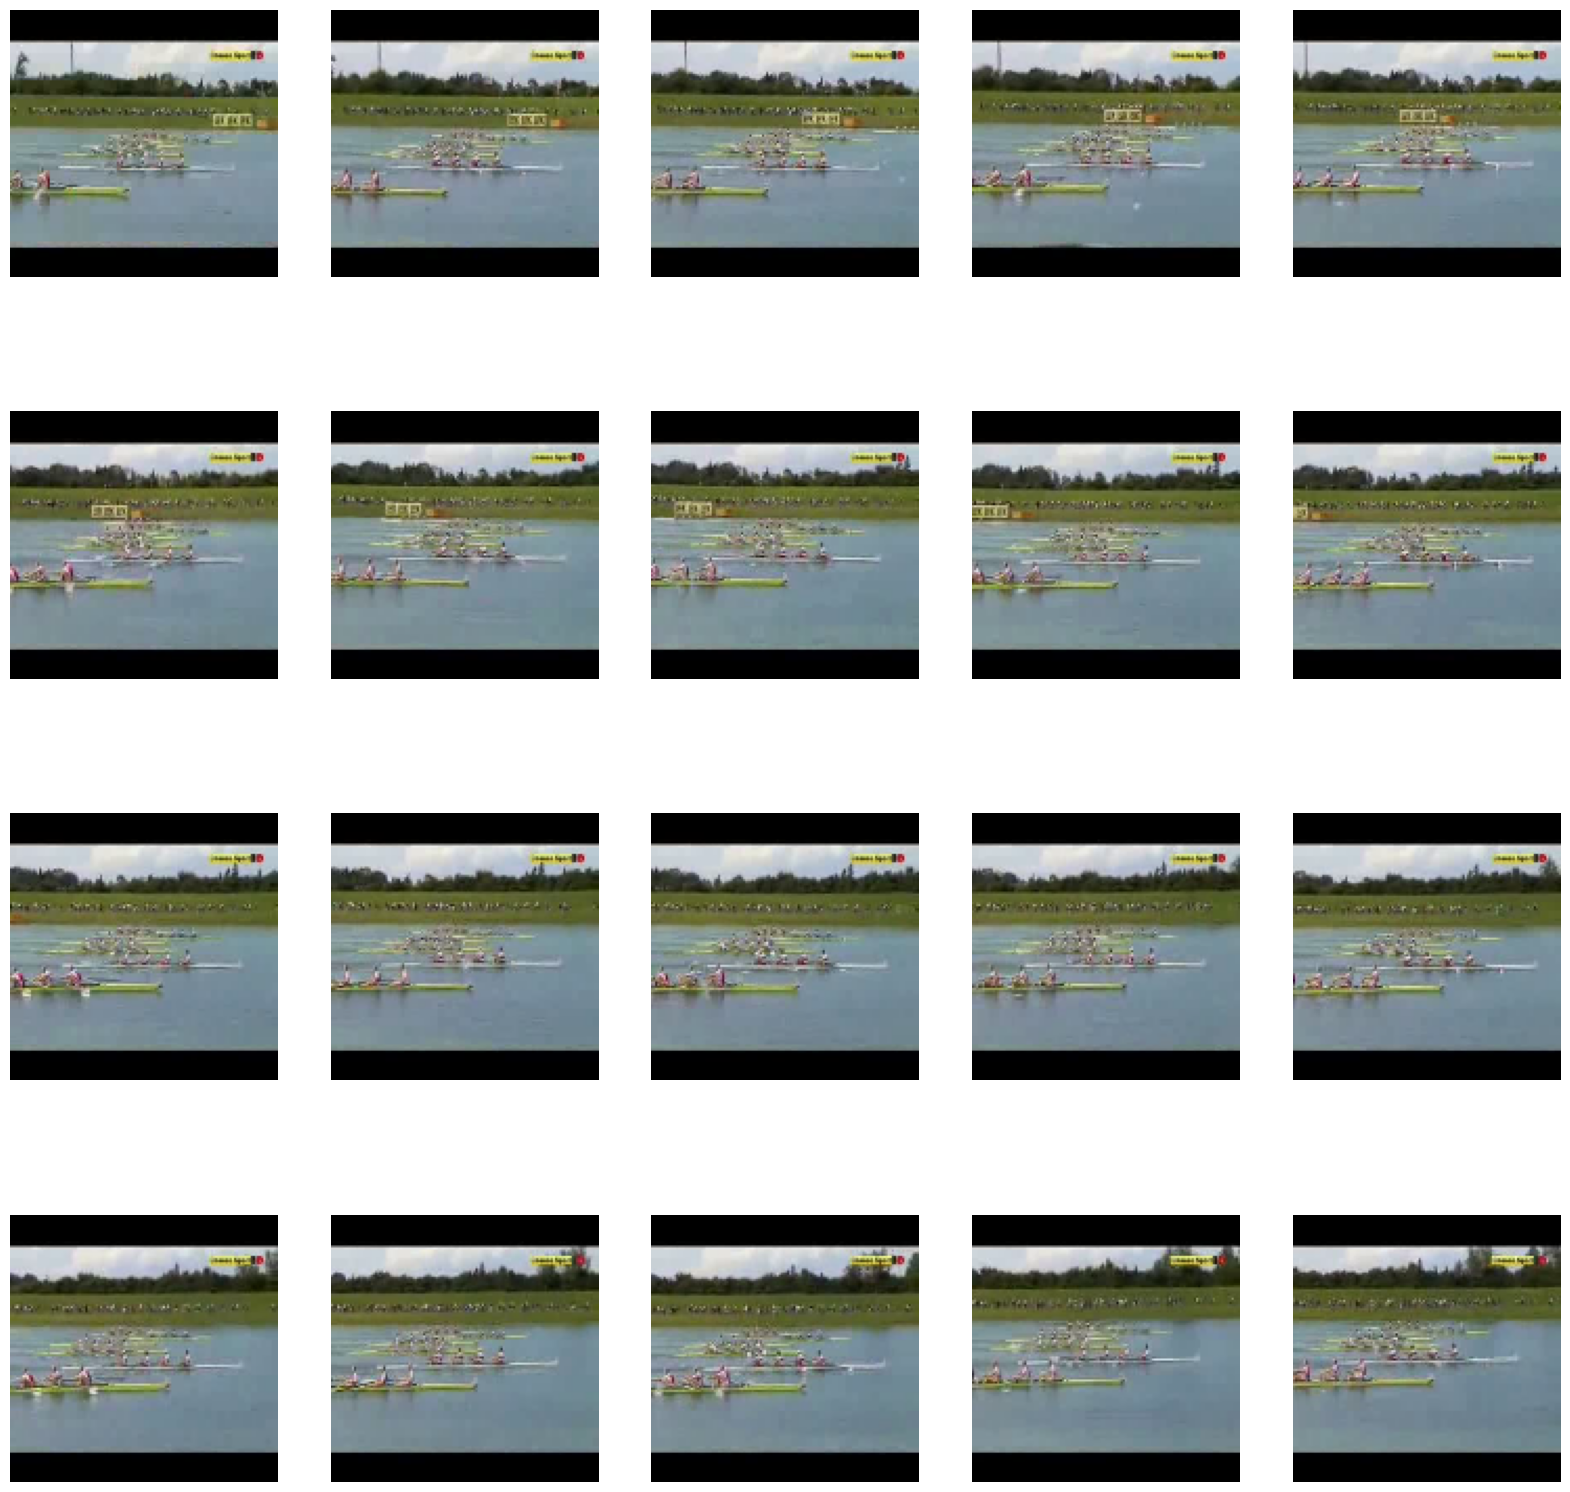

In [9]:
frames_list = []
video_reader = cv2.VideoCapture('data/UCF50/Rowing/v_Rowing_g03_c05.avi')
video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
skip_frames = max(int(video_frame_count/SEQUENCE_LENGTH), 1)
for i in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames)
    success, frame = video_reader.read()
    if not success:
        break
    resize_frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))
    norm_frame = resize_frame / 255.
    frames_list.append(norm_frame)
video_reader.release()

plt.figure(figsize=(20, 20))
for i in range(SEQUENCE_LENGTH):
    plt.subplot(4, 5, i+1)
    plt.imshow(cv2.cvtColor(np.float32(frames_list[i]), cv2.COLOR_BGR2RGB))
    plt.axis(False)

In [10]:
# Converting the above working as a function
def frames_extraction(video_path: str):
    """
    This function will extract frames at certain interval and apply transformation
    like resize and normalization and return all the frames in a list.

    Parameters: video_path: str, video file path in string format.

    Returns: frames_list: list, contains extracted and transformed frames.
    """
    frames_list = []
    # Reading the video file and counting the frames
    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Selecting the frames at certain interval and applying the transformation
    skip_frames = max(int(video_frame_count/SEQUENCE_LENGTH), 1)
    for i in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * skip_frames)
        success, frame = video_reader.read()
        if not success:
            break
        resize_frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))
        norm_frame = resize_frame/255.
        frames_list.append(norm_frame.astype('float32'))
    video_reader.release()
    return frames_list

In [11]:
# Creating a function to create a dataset containing all the data as per the classes_list.
def create_dataset(class_list: list):
    """
    This function will create a dataset containing the features, labels
    and video file path for all the videos.
    
    Parameters: class_list: list, A list containing the names of the video classes or category.
    
    Returns: features: A numpy array for all the extracted videos, 
             labels: A numpy array containing the classes in ordinal format,
             video_file_path: A list containing the path for all the videos.    
    """
    features = []
    labels = []
    video_files_path = []
    
    # Going through all the data in the class list
    for i, class_name in enumerate(class_list):
        print(f'[INFO] Extracting all the data in the class: {class_name}')

        # Getting the list of all the video files and the path to the video
        files_list = os.listdir(os.path.join(UCF50_DATA_PATH, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(UCF50_DATA_PATH, class_name, file_name)

            # Extracting frames using the function and verifying the total frames
            frames_list = frames_extraction(video_path=video_file_path)
            if len(frames_list) == SEQUENCE_LENGTH:

                # Appending the data in a list
                features.append(frames_list)
                labels.append(i)
                video_files_path.append(video_file_path)
    
    # Converting the list to array
    features = np.asarray(features)
    labels = np.asarray(labels)
    return features, labels, video_files_path

In [12]:
features, labels, video_files_path = create_dataset(class_list = CLASSES_LIST)

[INFO] Extracting all the data in the class: Biking
[INFO] Extracting all the data in the class: Diving
[INFO] Extracting all the data in the class: GolfSwing
[INFO] Extracting all the data in the class: Punch
[INFO] Extracting all the data in the class: Rowing


In [13]:
features.shape, labels.shape, video_files_path[:5]

((737, 20, 128, 128, 3),
 (737,),
 ['data/UCF50/Biking/v_Biking_g01_c03.avi',
  'data/UCF50/Biking/v_Biking_g08_c04.avi',
  'data/UCF50/Biking/v_Biking_g07_c02.avi',
  'data/UCF50/Biking/v_Biking_g24_c04.avi',
  'data/UCF50/Biking/v_Biking_g21_c08.avi'])

Now that the dataset created, lets convert the labels into OneHotEncoding format.

In [14]:
encoded_labels = to_categorical(labels)
encoded_labels.shape, encoded_labels[:5]

((737, 5),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], dtype=float32))

## Splitting and Configuring the Dataset

Now, that the dataset is been created and the labels are one hot encoded, we will split the dataset in training and testing dataset.

In [15]:
train_features, test_features, train_labels, test_labels = train_test_split(features, 
                                                                            encoded_labels, 
                                                                            test_size=0.25, 
                                                                            shuffle=True, 
                                                                            random_state=seed)

In [16]:
train_features.shape, train_labels.shape

((552, 20, 128, 128, 3), (552, 5))

In [17]:
test_features.shape, test_labels.shape

((185, 20, 128, 128, 3), (185, 5))

Now that the dataset is splitted, we can configure the dataset for performance by batching and prefetching the data.

In [18]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

2023-03-21 09:24:27.988616: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2170552320 exceeds 10% of free system memory.
2023-03-21 09:24:30.557176: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2170552320 exceeds 10% of free system memory.


In [19]:
train_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 20, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 20, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

2023-03-21 09:24:33.615699: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2170552320 exceeds 10% of free system memory.


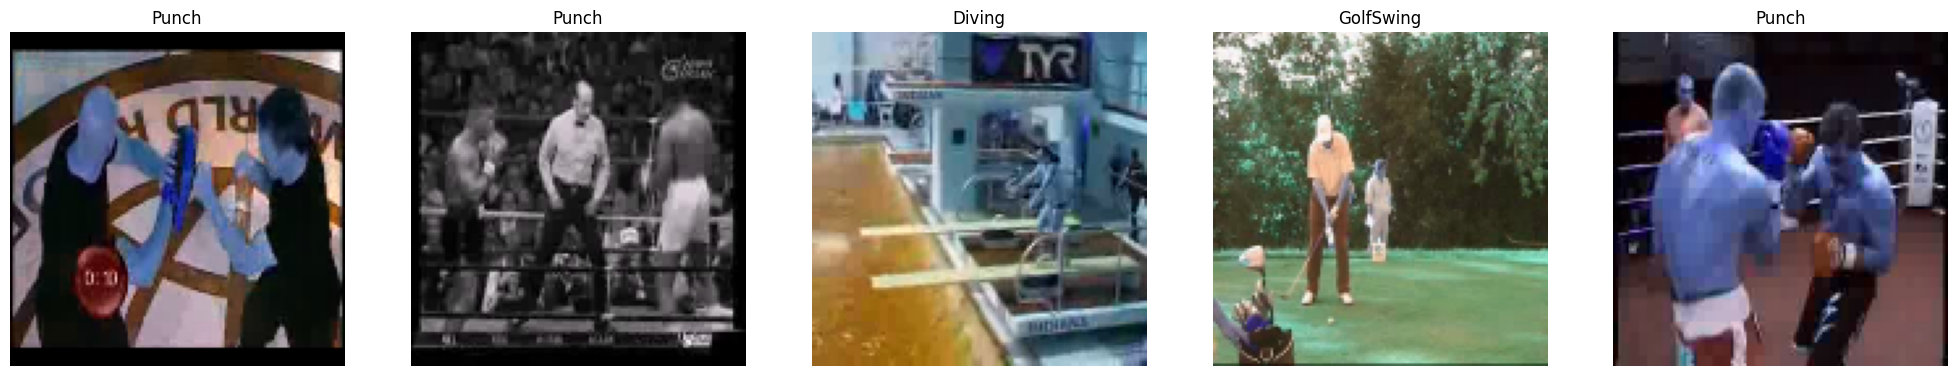

In [20]:
# Random testing the training dataset
plt.figure(figsize=(25, 5))
rand_test = next(iter(train_ds))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(rand_test[0][i][0])
    plt.title(CLASSES_LIST[rand_test[1][i].numpy().argmax()])
    plt.axis(False);

## Modeling

We will be creating two different architctures:
1. ConvLSTM
2. LRCN - Long Term Recurrent Convolutional Network

### Model 1 - ConvLSTM

In [21]:
class CreateConvlstmModel(Model):
    """
    Constructs and Initiates a ConvLSTM model for video classification.

    Parameters: 
        input_shape: tuple, Input shape of the array that is feeded in the model.
                     Format of the input_shape should be (timesteps, height, width, channels)
        num_classes: int, Total number of classes that model needs to predict.

    Returns: Fully Constructed ConvLSTM Model.
    """
    def __init__(self, input_shape: tuple, num_classes: int):
        super(CreateConvlstmModel, self).__init__()
        self.input_block1 = Sequential([
            ConvLSTM2D(4, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, input_shape=input_shape),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.2))
        ])
        self.block2 = Sequential([
            ConvLSTM2D(8, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.2))
        ])
        self.block3 = Sequential([
            ConvLSTM2D(12, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last'),
            TimeDistributed(Dropout(0.2))
        ])
        self.block4 = Sequential([
            ConvLSTM2D(16, 3, activation='tanh', data_format='channels_last', recurrent_dropout=0.2, return_sequences=True),
            MaxPooling3D((1, 2, 2), padding='same', data_format='channels_last')
        ])
        self.classifier_block = Sequential([
            Flatten(),
            Dense(num_classes, activation='softmax')
        ])
    
    def call(self, x):
        x = self.input_block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.classifier_block(x)

convlstm_model1 = CreateConvlstmModel(input_shape=(SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3), num_classes=len(CLASSES_LIST))

#### Checking Model Structure

In [22]:
convlstm_model1.build(input_shape=(BATCH_SIZE, SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3))
convlstm_model1.summary(expand_nested=True, show_trainable=True)

Model: "create_convlstm_model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential (Sequential)     (None, 20, 63, 63, 4)     1024      Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv_lstm2d (ConvLSTM2D)  (None, 20, 126, 126, 4)   1024      Y          |
|                                                                          |
| max_pooling3d (MaxPooling3D  (None, 20, 63, 63, 4)  0         Y          |
| )                                                                        |
|                                                                          |
| time_distributed (TimeDistr  (None, 20, 63, 63, 4)  0         Y          |
| ibuted)                                                                  |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_1 (Sequential)   (32, 20, 31, 31,

#### Compiling and Training the Model

First we will setup the callback this will help in monitoring the metrics and help in reducing the over fitting.<br>
We will be using two callbacks they are as follows:
1. Tensorboard: This callback helps in tracking and logging the performance of the models, it helps in comparing the results of multiple models in a visual dashboard. 
2. EarlyStopping: This callback monitors the training for some certain amount of training steps, and when the model does not improve it will stop the training.
3. ReduceLROnPlateau: Similar to the early stopping, it monitors the model training and when there's no improvement, it will reduce the learning rate of the optimizer to some extend. 

After the callbacks are created, we will compile the model with all the necessary configurations and fit the model for a certain number of epochs.

In [23]:
# creating tensorboard and early stopping callbacks
def create_tensorboard_callback(dir_name: str, exp_name: str):
    log_dir = dir_name + '/' + exp_name + '/' + dt.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')
    tensorboard_callabck = TensorBoard(log_dir=log_dir)
    print(f'[INFO] Saving Tensorboard log files to: {log_dir}')
    return tensorboard_callabck

early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=20,
                                        mode='min',
                                        verbose=1,
                                        restore_best_weights=True)

reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss',
                                       mode='min',
                                       factor=0.2,
                                       patience=10,
                                       verbose=1,
                                       min_lr=1e-7)

In [24]:
# Compiling the model
convlstm_model1.compile(loss='categorical_crossentropy', 
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

# Fitting the model
start_time = time.time()
model1_history = convlstm_model1.fit(train_ds,
                                     epochs=100,
                                     steps_per_epoch=len(train_ds),
                                     validation_data=test_ds,
                                     validation_steps=len(test_ds),
                                     callbacks=[create_tensorboard_callback(dir_name='training_logs', exp_name='convlstm_model1'),
                                                early_stopping_callback,
                                                reduce_lr_callback])
end_time = time.time()
training_time = end_time - start_time
print(f'\n[INFO] Total time taken to train the convlstm_model1 with early stopping:\nTotal Epochs: {len(model1_history.history["loss"])}\nTotal Training Time: {training_time:.2f} sec.')

[INFO] Saving Tensorboard log files to: training_logs/convlstm_model1/2023-03-21-09:24:38
Epoch 1/100
18/18 [==============================] - 45s 1s/step - loss: 1.4124 - accuracy: 0.4293 - val_loss: 1.2458 - val_accuracy: 0.5676 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 20s 1s/step - loss: 1.0873 - accuracy: 0.5924 - val_loss: 1.1780 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 20s 1s/step - loss: 0.9684 - accuracy: 0.6721 - val_loss: 1.2313 - val_accuracy: 0.5189 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 20s 1s/step - loss: 0.9105 - accuracy: 0.6685 - val_loss: 0.9458 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 20s 1s/step - loss: 0.6901 - accuracy: 0.7663 - val_loss: 0.6828 - val_accuracy: 0.7405 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 19s 1s/step - loss: 0.5430 - accuracy: 0.8025 - val_loss: 0.6518 - val_accuracy: 0.7297

#### Evaluate the Model

In [25]:
model1_eval_history = convlstm_model1.evaluate(test_ds)

6/6 [==============================] - 1s 224ms/step - loss: 0.4067 - accuracy: 0.8486


#### Saving the Model

In [26]:
model1_eval_loss, model1_eval_accuracy = model1_eval_history
model1_file_name = f"saved_model/convlstm_model1_{dt.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}_loss:{model1_eval_loss:.4f}_accuracy:{model1_eval_accuracy:.4f}"

# Saving the whole model
convlstm_model1.save(filepath=model1_file_name, save_format='tf')

INFO:tensorflow:Assets written to: saved_model/convlstm_model1_2023-03-21-09:36:57_loss:0.4067_accuracy:0.8486/assets


#### Ploting Model Training Curves

In [27]:
def plot_model_curves(history, best_epoch: int=None):
    """
    Plots separate loss and accuracy curves for training and validation metrics.
    
    Parameters:
        history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
        best_epoch: int(default: None), A integer for indicating the best epoch received during the model training by the early stopping callback.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    plt.figure(figsize=(15, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation accuracy')
    if best_epoch:
        plt.plot([best_epoch-1, best_epoch-1], plt.ylim(), linestyle='dashed', label=f'Best Epoch: {best_epoch}')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

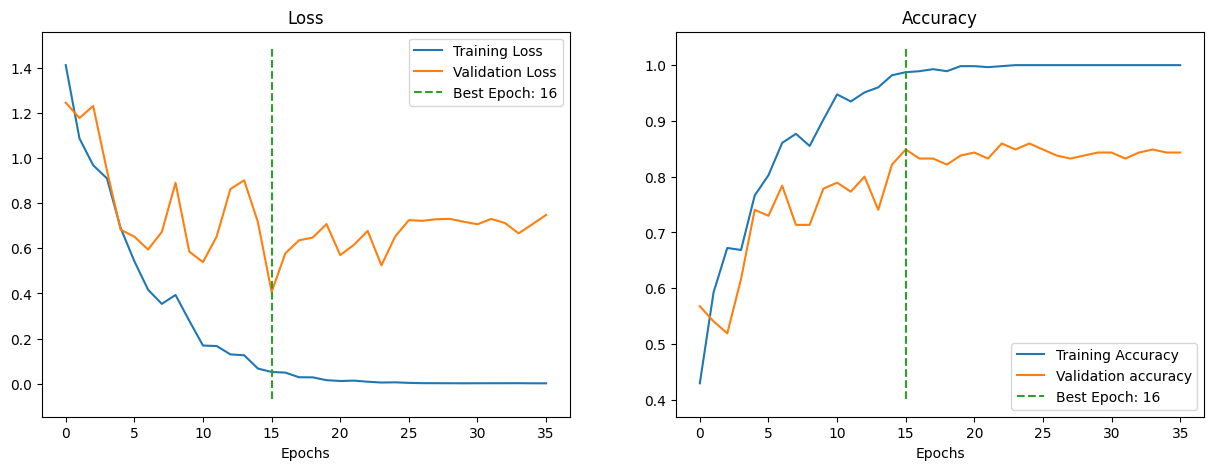

In [28]:
plot_model_curves(model1_history, best_epoch=16)

### Model 2 - LRCN

In [29]:
class CreateLRCNModel(Model):
    """
    Constructs and Initiates a LRCN model for video classification.

    Parameters: 
        input_shape: tuple, Input shape of the array that is feeded in the model.
                     Format of the input_shape should be (timesteps, height, width, channels)
        num_classes: int, Total number of classes that model needs to predict.

    Returns: Fully Constructed LRCN Model.
    """
    def __init__(self, input_shape: tuple, num_classes: int):
        super(CreateLRCNModel, self).__init__()
        self.input_block1 = Sequential([
            TimeDistributed(Conv2D(16, 3, padding='same', activation='relu'), input_shape=input_shape),
            TimeDistributed(MaxPooling2D(4)),
            TimeDistributed(Dropout(0.25))
        ])
        self.block2 = Sequential([
            TimeDistributed(Conv2D(32, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(4)),
            TimeDistributed(Dropout(0.25))
        ])
        self.block3 = Sequential([
            TimeDistributed(Conv2D(64, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(2)),
            TimeDistributed(Dropout(0.25))
        ])
        self.block4 = Sequential([
            TimeDistributed(Conv2D(64, 3, padding='same', activation='relu')),
            TimeDistributed(MaxPooling2D(2))
        ])
        self.classifier_block = Sequential([
            TimeDistributed(Flatten()),
            LSTM(32),
            Dense(num_classes, activation='softmax')
        ])
        
    def call(self, x):
        x = self.input_block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        return self.classifier_block(x)

lrcn_model2 = CreateLRCNModel(input_shape=(SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3), num_classes=len(CLASSES_LIST))

#### Checking Model Structure

In [30]:
lrcn_model2.build(input_shape=(BATCH_SIZE, SEQUENCE_LENGTH, FRAME_HEIGHT, FRAME_WIDTH, 3))
lrcn_model2.summary(expand_nested=True, show_trainable=True)

Model: "create_lrcn_model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_5 (Sequential)   (None, 20, 32, 32, 16)    448       Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| time_distributed_3 (TimeDis  (None, 20, 128, 128, 16)  448    Y          |
| tributed)                                                                |
|                                                                          |
| time_distributed_4 (TimeDis  (None, 20, 32, 32, 16)  0        Y          |
| tributed)                                                                |
|                                                                          |
| time_distributed_5 (TimeDis  (None, 20, 32, 32, 16)  0        Y          |
| tributed)                                                                |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

#### Compiling and Training the Model

Similar to the above model we will compile the model and train it for some certain number of epochs and also customize the training behaviour using the previously initiated callbacks.

In [31]:
# Compiling the model
lrcn_model2.compile(loss='categorical_crossentropy', 
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

# Fitting the model
start_time = time.time()
model2_history = lrcn_model2.fit(train_ds,
                                 epochs=100,
                                 steps_per_epoch=len(train_ds),
                                 validation_data=test_ds,
                                 validation_steps=len(test_ds),
                                 callbacks=[create_tensorboard_callback(dir_name='training_logs', exp_name='lrcn_model2'),
                                            early_stopping_callback,
                                            reduce_lr_callback])
end_time = time.time()
training_time = end_time - start_time
print(f'\n[INFO] Total time taken to train the lrcn_model2 with early stopping:\nTotal Epochs: {len(model2_history.history["loss"])}\nTotal Training Time: {training_time:.2f} sec.')

[INFO] Saving Tensorboard log files to: training_logs/lrcn_model2/2023-03-21-09:37:12
Epoch 1/100
18/18 [==============================] - 7s 216ms/step - loss: 1.6023 - accuracy: 0.2373 - val_loss: 1.5808 - val_accuracy: 0.3351 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 3s 166ms/step - loss: 1.4090 - accuracy: 0.4348 - val_loss: 1.2222 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 3s 168ms/step - loss: 1.1166 - accuracy: 0.5272 - val_loss: 1.0940 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 3s 165ms/step - loss: 1.0185 - accuracy: 0.5688 - val_loss: 0.9296 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 3s 166ms/step - loss: 0.8790 - accuracy: 0.6558 - val_loss: 0.8161 - val_accuracy: 0.6811 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 3s 166ms/step - loss: 0.8437 - accuracy: 0.7029 - val_loss: 0.7970 - val_accuracy

#### Evaluate the Model

In [32]:
model2_eval_history = lrcn_model2.evaluate(test_ds)

6/6 [==============================] - 0s 62ms/step - loss: 0.1253 - accuracy: 0.9622


#### Saving the Model

In [33]:
model2_eval_loss, model2_eval_accuracy = model2_eval_history
model2_file_name = f"saved_model/lrcn_model2_{dt.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}_loss:{model2_eval_loss:.4f}_accuracy:{model2_eval_accuracy:.4f}"

# Saving the whole model
lrcn_model2.save(filepath=model2_file_name, save_format='tf')

INFO:tensorflow:Assets written to: saved_model/lrcn_model2_2023-03-21-09:40:09_loss:0.1253_accuracy:0.9622/assets


INFO:tensorflow:Assets written to: saved_model/lrcn_model2_2023-03-21-09:40:09_loss:0.1253_accuracy:0.9622/assets


Note: The above warning can be ignored, this type of warnings are present in the documentation of the tensorflow api.

#### Ploting Model Training Curves

We will use the same function we had created earlier for the ConvLSTM Model and plot the loss and accuracy curves of the LRCN Model.

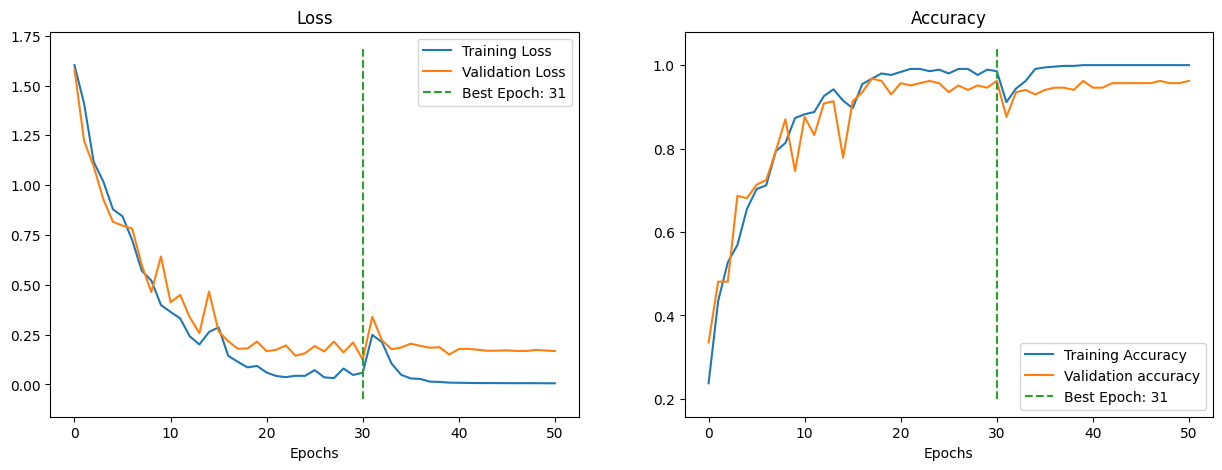

In [46]:
plot_model_curves(history=model2_history, best_epoch=31)

## Model Testing and Visualization

### Downloading Youtube Videos

To test the model on unknown videos, we will need to download the videos from youtube which has a collection of videos on any topics, using that video we will verify the models performance.

So first we will create a helper function that downloads any videos from youtube when URL is provided.

In [35]:
def download_yt_videos(yt_url_list: list, save_dir: str):
    """
    Download any youtube videos using this helper function.
    
    Parameters:
        yt_url_list: list, A list containing all the url of the youtube videos.
        save_dir: str, A string mentioning the name of the directory in which the 
                       videos needs to be saved.
    Returns: file_path_list: list, A list containing all the videos file path. 
    """
    # Creating a empty list to store downloaded file paths.
    file_path_list = []
    for url in yt_url_list:
        video = YouTube(url=url)
        
        # Getting the title and the video url
        title = video.title
        video_url = video.streaming_data.get('formats')[-1]['url']

        # Checking the save directory
        if not os.path.exists(save_dir):
            print('[INFO] Creating a output directory to store the video.\n')
            os.makedirs(save_dir, exist_ok=True)
        
        # Downloading and saving to the directory
        file_path = f'{save_dir}/{title}.mp4'
        file_path_list.append(file_path)
        urlretrieve(video_url, file_path)
        print(f"[INFO] Video '{title}' is been downloaded in: '{file_path}'")
    return file_path_list

In [38]:
# Downloading youtube videos
testing_data_list = download_yt_videos(yt_url_list=['https://www.youtube.com/watch?v=-y0yqOauULI',
                                                    'https://www.youtube.com/watch?v=IEEENsZnu48',
                                                    'https://www.youtube.com/watch?v=2t-Wta4GFxQ',
                                                    'https://www.youtube.com/watch?v=8uN05mo1fI0',
                                                    'https://www.youtube.com/shorts/c_U5g6UaG8E'], 
                                       save_dir='test_data')

[INFO] Video 'CYCLING MOTIVATION | 1 MINUTE EDIT' is been downloaded in: 'test_data/CYCLING MOTIVATION | 1 MINUTE EDIT.mp4'
[INFO] Video 'Filipino Dive Fail - SEA Games 2015 - Splash Brothers!' is been downloaded in: 'test_data/Filipino Dive Fail - SEA Games 2015 - Splash Brothers!.mp4'
[INFO] Video 'MiMatch Fitting Experience - 30 seconds' is been downloaded in: 'test_data/MiMatch Fitting Experience - 30 seconds.mp4'
[INFO] Video '30 Second Rowing Informational Commercial' is been downloaded in: 'test_data/30 Second Rowing Informational Commercial.mp4'
[INFO] Video 'Mike tyson The Beast of Boxing 🥊 😱One Punch Man🥊💪' is been downloaded in: 'test_data/Mike tyson The Beast of Boxing 🥊 😱One Punch Man🥊💪.mp4'


### Single Prediction on Videos

Now we will create a function that can predict on a single class videos, here we will use a similar method that we used in the preprocessing stage, extracting only certain number of frame as a Sequence length and predicting the class using the best architecture the LRCN Model. 

In [39]:
def predict_class_video(video_file_path: str, sequence_length: int=20):
    """
    Predict Video class using the LRCN Model and prints the predicted class and the probability score.
    
    Parameters:
        video_file_path: str, file path od the video in string format.
        sequence_length: int(default: 20), the timesteps number used for training the model.
    """
    # Reading the video file
    video_reader = cv2.VideoCapture(video_file_path)
    
    # Extracting frames at certain interval for max sequence length.
    frames_list = []
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames = max(int(total_frames/sequence_length), 1)
    
    # Looping and extracting
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames)
        success, frame = video_reader.read()
        if not success:
            break
        resize_frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))
        norm_frame = resize_frame/255.
        frames_list.append(norm_frame.astype('float32'))
    
    # predicting using the LRCN model 
    pred_prob = lrcn_model2.predict(np.expand_dims(frames_list, axis=0))[0]
    pred_label = np.argmax(pred_prob)
    pred_class = CLASSES_LIST[pred_label]
    
    # printing the result
    print(f'[INfO] Action Predicted: {pred_class}')
    print(f'[INFO] Prediction Probalities: {pred_prob[pred_label]:.2f}\n')
    video_reader.release()

Testing the videos which were downloaded earlier using the function.

In [40]:
# Change the index(range 0-4) to predict different files.
video_path = testing_data_list[4]

# predicting and visualizing the video
print(f'File: {video_path}')
predict_class_video(video_file_path=video_path, sequence_length=SEQUENCE_LENGTH)
Video(video_path, width=500)

File: test_data/Mike tyson The Beast of Boxing 🥊 😱One Punch Man🥊💪.mp4
1/1 [==============================] - 1s 602ms/step
[INfO] Action Predicted: Punch
[INFO] Prediction Probalities: 0.99



### Multiple Prediction on Videos

We will now create a function that will read the downloaded video file and predict the classes in the video, after that the function will save the video file with the result.

In [41]:
# Downloading a youtube videos
testing_data_list2 = download_yt_videos(yt_url_list=['https://youtu.be/oDTEpe6Lb3M',], save_dir='test_data')

[INFO] Video 'Sports compilation' is been downloaded in: 'test_data/Sports compilation.mp4'


In [42]:
def predict_save_video(video_file_path: str, result_file_name: str, sequence_length: int=20):
    """
    Predict Video class for every timesteps using the LRCN Model and return the result class in the video.
    
    Parameters:
        video_file_path: str, file path od the video in string format.
        result_file_name: str, file name to store the final video.
        sequence_length: int(default: 20), the timesteps number used for training the model.
    """
    video_reader = cv2.VideoCapture(video_file_path)
    org_vid_ht = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    org_vid_wd = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

    video_writer = cv2.VideoWriter(result_file_name, 
                                   cv2.VideoWriter_fourcc('V', 'P', '0', '9'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (org_vid_wd, org_vid_ht))
    
    frame_queue = deque(maxlen=sequence_length)
    pred_class = ''
    while video_reader.isOpened():
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (FRAME_HEIGHT, FRAME_WIDTH))
        norm_frame = resized_frame/255.
        frame_queue.append(norm_frame.astype('float32'))
        if len(frame_queue) == sequence_length:
            pred_prob = lrcn_model2.predict(np.expand_dims(frame_queue, axis=0), verbose=0)[0]
            pred_label = np.argmax(pred_prob)
            pred_class = CLASSES_LIST[pred_label]
        frame_cpy = frame.copy()
        cv2.rectangle(frame, (0, int(org_vid_ht-50)), (org_vid_wd, org_vid_ht), (0,0,0), cv2.FILLED)
        cv2.putText(frame, pred_class, (int(org_vid_wd/2.4), int(org_vid_ht-15)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        frame_overlay = cv2.addWeighted(frame, 0.4, frame_cpy, 0.6, 0)
        video_writer.write(frame_overlay)
    video_reader.release()
    video_writer.release()

In [43]:
predict_save_video(testing_data_list2[0], 'video.mp4')
Video('video.mp4', width=500)

OpenCV: FFMPEG: tag 0x39305056/'VP09' is not supported with codec id 167 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x39307076/'vp09'
